# **TP 3 – Exercice 1 : Classification binaire sur Iris Comparaison : Descente de Gradient (GD) vs Gradient Stochastique (SGD)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 12})

***FONCTIONS POUR LA CLASSIFICATION***

In [2]:
# ------------------------------
# FONCTIONS POUR LA CLASSIFICATION
# ------------------------------

def sigmoid(t):
    t = np.clip(t, -500, 500)
    return 1.0 / (1.0 + np.exp(-t))

def logistic_loss(w, X, y):
    z = y * (X @ w)
    return np.mean(np.logaddexp(0, -z))

def grad_logistic(w, X, y):
    """Gradient complet (pour GD)."""
    z = y * (X @ w)
    sigma = sigmoid(-z)
    return -(X.T @ (y * sigma)) / len(y)

def grad_logistic_i(w, x_i, y_i):
    """Gradient stochastique (pour SGD)."""
    z = y_i * (x_i @ w)
    sigma = sigmoid(-z)
    return -y_i * x_i * sigma

***ALGORITHMES***

In [3]:
# ------------------------------
# ALGORITHMES
# ------------------------------

def gd(w0, X, y, alpha, max_iter=100):
    """Descente de Gradient classique (déterministe)."""
    w = w0.copy()
    losses = []
    for k in range(max_iter):
        g = grad_logistic(w, X, y)
        w -= alpha * g
        losses.append(logistic_loss(w, X, y))
    return w, losses

def sgd(w0, X, y, alpha0, epochs=50):
    """Gradient Stochastique (SGD from scratch)."""
    n, d = X.shape
    w = w0.copy()
    losses = []
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            alpha = alpha0 / (1.0 + k)
            g = grad_logistic_i(w, X[i], y[i])
            w -= alpha * g
            k += 1
        losses.append(logistic_loss(w, X, y))
    return w, losses

***DONNÉES : IRIS (CLASSIFICATION BINAIRE)***

In [4]:
iris = load_iris()
X_raw, y_raw = iris.data, iris.target

# Binarisation : Setosa (0) vs autres (1)
y_bin = (y_raw == 0).astype(int)
y = 2 * y_bin - 1  # → {-1, +1}
mask = y != 0       # Garder Setosa vs Versicolor
X, y = X_raw[mask], y[mask]

# Ajout de biais + standardisation
X = np.hstack([np.ones((X.shape[0], 1)), X])
scaler = StandardScaler()
X[:, 1:] = scaler.fit_transform(X[:, 1:])

n, d = X.shape
w0 = np.zeros(d)

***EXÉCUTION ET VISUALISATION : GD vs SGD***

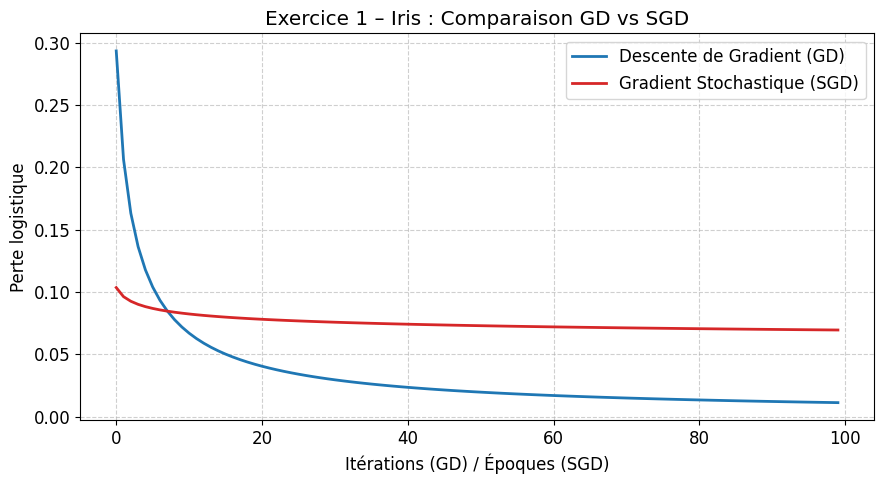

In [5]:
# Descente de Gradient classique
_, losses_gd = gd(w0, X, y, alpha=1.0, max_iter=100)

# Gradient Stochastique
_, losses_sgd = sgd(w0, X, y, alpha0=1.0, epochs=100)

plt.figure(figsize=(9, 5))
plt.plot(losses_gd, label='Descente de Gradient (GD)', linewidth=2, color='tab:blue')
plt.plot(losses_sgd, label='Gradient Stochastique (SGD)', linewidth=2, color='tab:red')
plt.xlabel('Itérations (GD) / Époques (SGD)')
plt.ylabel('Perte logistique')
plt.title('Exercice 1 – Iris : Comparaison GD vs SGD')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# **TP 3 – Exercices 2 & 3 : Régression sur California Housing**
# **Exercice 2 : Impact de la standardisation**
# **Exercice 3 : Comparaison SGD / Mini-batch / Adam**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 12})

***FONCTIONS POUR LA RÉGRESSION***

In [7]:
def mse_loss(w, X, y):
    """Mean Squared Error."""
    return np.mean((X @ w - y)**2)

def grad_mse(w, X, y):
    """Gradient complet (pour référence)."""
    return (2.0 / len(y)) * X.T @ (X @ w - y)

def grad_mse_i(w, x_i, y_i):
    """Gradient stochastique (un seul échantillon)."""
    return 2.0 * (x_i @ w - y_i) * x_i

***ALGORITHMES POUR LA RÉGRESSION***

In [8]:
def sgd_mse(w0, X, y, alpha0, epochs=100):
    """SGD pur (batch_size = 1)."""
    n, d = X.shape
    w = w0.copy()
    losses = []
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            alpha = alpha0 / (1.0 + k)
            g = grad_mse_i(w, X[i], y[i])
            w -= alpha * g
            k += 1
        losses.append(mse_loss(w, X, y))
    return w, losses

def minibatch_sgd_mse(w0, X, y, batch_size, alpha0, epochs=100):
    """Mini-batch SGD."""
    n, d = X.shape
    w = w0.copy()
    losses = []
    k = 0
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            batch_idx = idx[start:start+batch_size]
            g_batch = np.mean([grad_mse_i(w, X[i], y[i]) for i in batch_idx], axis=0)
            alpha = alpha0 / (1.0 + k)
            w -= alpha * g_batch
            k += 1
        losses.append(mse_loss(w, X, y))
    return w, losses

def adam_mse(w0, X, y, alpha=0.01, beta1=0.9, beta2=0.999, eps=1e-8, epochs=100):
    """Adam (implémentation manuelle)."""
    w = w0.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    losses = []
    t = 0
    n = X.shape[0]
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in idx:
            t += 1
            g = grad_mse_i(w, X[i], y[i])
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * g**2
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            w -= alpha * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(mse_loss(w, X, y))
    return w, losses

***CHARGEMENT ET PRÉTRAITEMENT***

In [9]:
print("=== Chargement des données California Housing ===")
california = fetch_california_housing()
X_raw, y_raw = california.data, california.target

# Sous-échantillonnage pour accélérer
np.random.seed(42)
idx = np.random.choice(len(X_raw), 5000, replace=False)
X_raw, y_raw = X_raw[idx], y_raw[idx]

# Données BRUTES (sous-échantillon plus petit pour SGD sans standardisation)
X_brut = X_raw[:1000]
y_brut = y_raw[:1000]
w0_brut = np.zeros(X_brut.shape[1])

# Données STANDARDISÉES (taille complète)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_X.fit_transform(X_raw)
y_std = scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()
w0_std = np.zeros(X_std.shape[1])

print(f"Données brutes   : {X_brut.shape}")
print(f"Données normalisées : {X_std.shape}")

=== Chargement des données California Housing ===
Données brutes   : (1000, 8)
Données normalisées : (5000, 8)


***EXERCICE 2 : IMPACT DE LA STANDARDISATION***


=== Exercice 2 : Standardisation ===


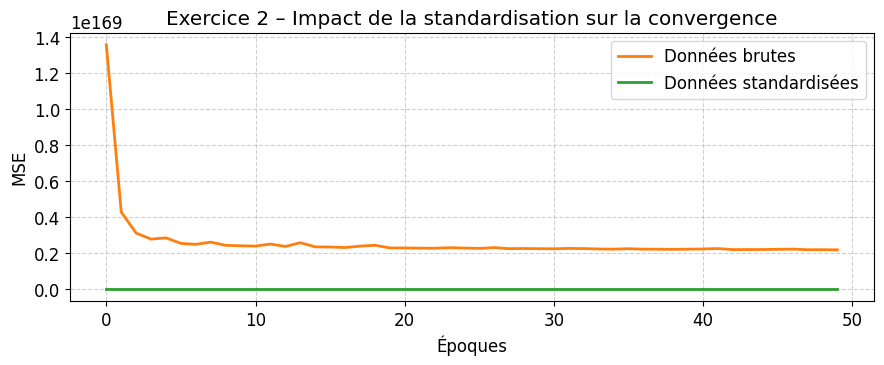

In [10]:
print("\n=== Exercice 2 : Standardisation ===")

# SGD sur données BRUTES
_, losses_brut = sgd_mse(w0_brut, X_brut, y_brut, alpha0=0.0001, epochs=50)

# SGD sur données STANDARDISÉES
_, losses_std = sgd_mse(w0_std, X_std, y_std, alpha0=0.1, epochs=50)

# Visualisation
plt.figure(figsize=(9, 4))
plt.plot(losses_brut, label='Données brutes', linewidth=2, color='tab:orange')
plt.plot(losses_std, label='Données standardisées', linewidth=2, color='tab:green')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.title('Exercice 2 – Impact de la standardisation sur la convergence')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

***EXERCICE 3 : COMPARAISON DES OPTIMISEURS***


=== Exercice 3 : Comparaison des optimiseurs ===


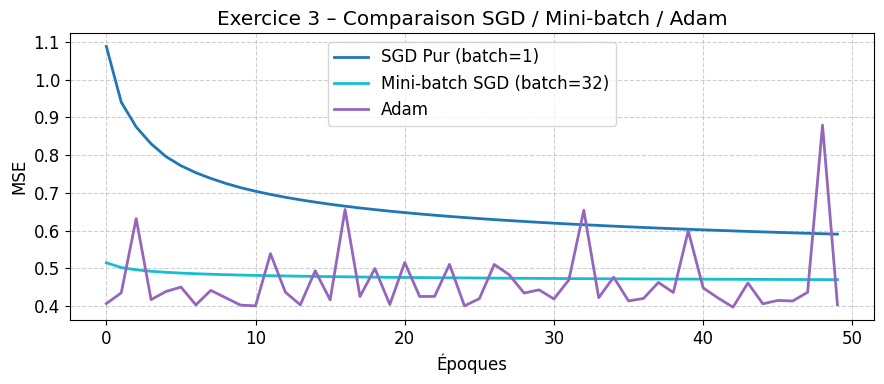

In [11]:
print("\n=== Exercice 3 : Comparaison des optimiseurs ===")

# SGD pur (batch_size = 1)
_, losses_sgd = sgd_mse(w0_std, X_std, y_std, alpha0=0.1, epochs=50)

# Mini-batch SGD (batch_size = 32)
_, losses_mini = minibatch_sgd_mse(w0_std, X_std, y_std, batch_size=32, alpha0=0.1, epochs=50)

# Adam
_, losses_adam = adam_mse(w0_std, X_std, y_std, alpha=0.01, epochs=50)

# Visualisation
plt.figure(figsize=(9, 4))
plt.plot(losses_sgd, label='SGD Pur (batch=1)', linewidth=2, color='tab:blue')
plt.plot(losses_mini, label='Mini-batch SGD (batch=32)', linewidth=2, color='tab:cyan')
plt.plot(losses_adam, label='Adam', linewidth=2, color='tab:purple')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.title('Exercice 3 – Comparaison SGD / Mini-batch / Adam')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()